In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
class TitanicDataset(Dataset):

    def __init__(self, csv_file, train):
        self.train = train
        self.titanic_X, self.titanic_y = self.preprocessing(csv_file)
        return
    
    def preprocessing(self, csv_path):
        titanic_df = pd.read_csv(csv_path)

        titanic_X = titanic_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']]
        titanic_y = titanic_df['Survived']

        categorical_columns = titanic_X.select_dtypes(exclude=np.number).columns
        imp_freq = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        titanic_X.loc[:, categorical_columns] = imp_freq.fit_transform(titanic_X[categorical_columns])

        numeric_columns = titanic_X.select_dtypes(include=np.number).columns
        imp_mean = SimpleImputer(missing_values=np.nan, strategy="mean")
        titanic_X.loc[:, numeric_columns] = imp_mean.fit_transform(titanic_X[numeric_columns])

        titanic_X = pd.get_dummies(titanic_X)

        X_train, X_test, y_train, y_test = train_test_split(
            titanic_X, titanic_y, test_size=0.2, random_state=42
        )

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        if not self.train:
            X_test = scaler.transform(X_test)

        if self.train:
            ret = pd.DataFrame(X_train), pd.DataFrame(y_train)
        else:
            ret = pd.DataFrame(X_test), pd.DataFrame(y_test)
   
        return ret
    
    def __len__(self):
        return len(self.titanic_X)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return torch.Tensor(self.titanic_X.iloc[idx]), torch.Tensor(self.titanic_y.iloc[idx])


In [4]:
titanic_train = TitanicDataset('data/titanic.csv', train=True)
titanic_val = TitanicDataset('data/titanic.csv', train=False)

train_loader = DataLoader(
    titanic_train,
    batch_size=16, shuffle=True)

test_loader = DataLoader(
    titanic_val,
    batch_size=16, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape


C:\Users\phili\AppData\Local\Temp\ipykernel_19160\1401008552.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(self.titanic_X.iloc[idx]), torch.Tensor(self.titanic_y.iloc[idx])


torch.Size([16, 10])

In [6]:
class Net(torch.nn.Module):
  def __init__(self, D_in, H, D_out, device="cpu"):
    super(Net, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, D_out)
    self.device = device

  def forward(self, x):
    h_relu = self.linear1(x).clamp(min=0)
    y_pred = self.linear2(h_relu)
    return F.sigmoid(y_pred)

In [7]:
n_epochs = 50
learning_rate = 0.01
momentum = 0.5
log_interval = 10

def train(network, optimizer, epoch):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(network.device), target.to(network.device)
                
        optimizer.zero_grad()
        
        output = network(data)
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )

    return network

In [8]:
def test(network, epoch=0, acc_test=[], acc_train=[], epoch_counter=[]):
  network.eval()
  
  correct_test = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(network.device), target.to(network.device)
      
      output = network(data)
      pred = output.round()
      correct_test += pred.eq(target.data.view_as(pred)).sum()
  acc_test_per = 100. * correct_test / len(test_loader.dataset)
  print('\nTest set: Accuracy: {}/{} ({:.0f}%)'.format(
    correct_test, len(test_loader.dataset),
    100. * correct_test / len(test_loader.dataset)))
  
  correct_train = 0
  with torch.no_grad():
    for data, target in train_loader:
      data, target = data.to(network.device), target.to(network.device)
      
      output = network(data)
      pred = output.round()
      correct_train += pred.eq(target.data.view_as(pred)).sum()
  acc_train_per = 100. * correct_train / len(train_loader.dataset)
  print('Train set: Accuracy: {}/{} ({:.0f}%)\n'.format(
    correct_train, len(train_loader.dataset),
    100. * correct_train / len(train_loader.dataset)))
  
  epoch_counter.append(epoch)
  acc_test.append(acc_test_per)
  acc_train.append(acc_train_per)
  
  return acc_test, acc_train, epoch_counter

In [9]:
D_in, H, D_out = 10, 3, 1

network = Net(D_in, H, D_out)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                    momentum=momentum)

In [10]:
acc_test, acc_train, epoch_counter = [], [], []

test(network, 0, acc_test, acc_train, epoch_counter)
for epoch in range(1, n_epochs + 1):
    train(network, optimizer, epoch)
    test(network, epoch, acc_test, acc_train, epoch_counter)




C:\Users\phili\AppData\Local\Temp\ipykernel_19160\1401008552.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(self.titanic_X.iloc[idx]), torch.Tensor(self.titanic_y.iloc[idx])



Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 1 [0/712 (0%)]	Loss: 0.770353
Train Epoch: 1 [160/712 (22%)]	Loss: 0.700075
Train Epoch: 1 [320/712 (44%)]	Loss: 0.706390
Train Epoch: 1 [480/712 (67%)]	Loss: 0.748723
Train Epoch: 1 [640/712 (89%)]	Loss: 0.732991

Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 2 [0/712 (0%)]	Loss: 0.751580
Train Epoch: 2 [160/712 (22%)]	Loss: 0.684462
Train Epoch: 2 [320/712 (44%)]	Loss: 0.587367
Train Epoch: 2 [480/712 (67%)]	Loss: 0.778356
Train Epoch: 2 [640/712 (89%)]	Loss: 0.616883

Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 3 [0/712 (0%)]	Loss: 0.678683
Train Epoch: 3 [160/712 (22%)]	Loss: 0.586449
Train Epoch: 3 [320/712 (44%)]	Loss: 0.610718
Train Epoch: 3 [480/712 (67%)]	Loss: 0.698285
Train Epoch: 3 [640/712 (89%)]	Loss: 0.569636

Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 4 [0/712 (0%)]	Loss: 0

In [13]:
def plot_acc(acc_test, acc_train, epoch_counter):
    fig = plt.figure()
    plt.plot(epoch_counter, acc_train, color='blue')
    plt.plot(epoch_counter, acc_test, color='red')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')

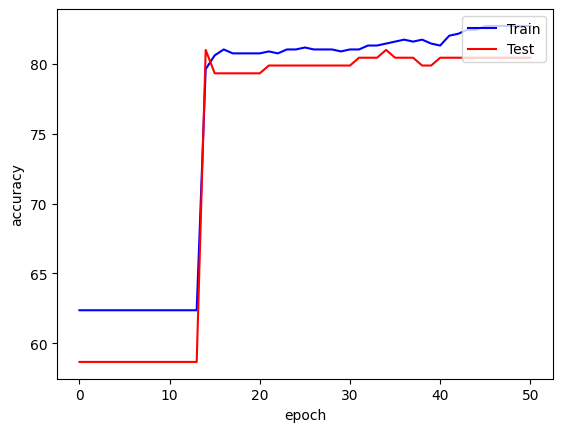

In [14]:
plot_acc(acc_test, acc_train, epoch_counter)

In [16]:
class Net2(torch.nn.Module):
  def __init__(self, D_in, H, D_out, device="cpu"):
    super(Net2, self).__init__()
    self.linear1 = torch.nn.Linear(D_in, H)
    self.linear2 = torch.nn.Linear(H, H)
    self.linear3 = torch.nn.Linear(H, H)
    self.linear4 = torch.nn.Linear(H, H)
    self.linear5 = torch.nn.Linear(H, H)
    self.linear6 = torch.nn.Linear(H, D_out)
    self.device = device

  def forward(self, x):
    h1 = self.linear1(x).clamp(min=0)
    h2 = self.linear2(h1).clamp(min=0)
    h3 = self.linear3(h2).clamp(min=0)
    h4 = self.linear4(h3).clamp(min=0)
    h5 = self.linear5(h4).clamp(min=0)
    y_pred = self.linear6(h5)
    return F.sigmoid(y_pred)

In [17]:
H = 800

network = Net2(D_in, H, D_out)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                    momentum=momentum)

acc_test, acc_train, epoch_counter = [], [], []

test(network, 0, acc_test, acc_train, epoch_counter)
for epoch in range(1, n_epochs + 1):
    train(network, optimizer, epoch)
    test(network, epoch, acc_test, acc_train, epoch_counter)


C:\Users\phili\AppData\Local\Temp\ipykernel_19160\1401008552.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.Tensor(self.titanic_X.iloc[idx]), torch.Tensor(self.titanic_y.iloc[idx])



Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 1 [0/712 (0%)]	Loss: 0.692259
Train Epoch: 1 [160/712 (22%)]	Loss: 0.683765
Train Epoch: 1 [320/712 (44%)]	Loss: 0.675269
Train Epoch: 1 [480/712 (67%)]	Loss: 0.692646
Train Epoch: 1 [640/712 (89%)]	Loss: 0.658518

Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 2 [0/712 (0%)]	Loss: 0.685067
Train Epoch: 2 [160/712 (22%)]	Loss: 0.694736
Train Epoch: 2 [320/712 (44%)]	Loss: 0.681589
Train Epoch: 2 [480/712 (67%)]	Loss: 0.681677
Train Epoch: 2 [640/712 (89%)]	Loss: 0.622400

Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 3 [0/712 (0%)]	Loss: 0.680603
Train Epoch: 3 [160/712 (22%)]	Loss: 0.711583
Train Epoch: 3 [320/712 (44%)]	Loss: 0.679863
Train Epoch: 3 [480/712 (67%)]	Loss: 0.656586
Train Epoch: 3 [640/712 (89%)]	Loss: 0.656162

Test set: Accuracy: 105/179 (59%)
Train set: Accuracy: 444/712 (62%)

Train Epoch: 4 [0/712 (0%)]	Loss: 0

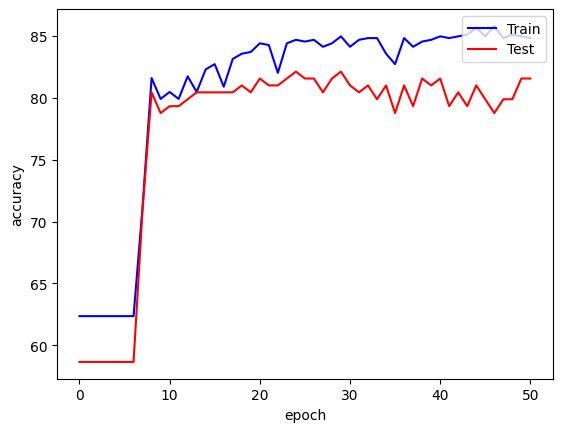

In [18]:
plot_acc(acc_test, acc_train, epoch_counter)